# ДЗ-2 по Теории и практике онлайн экспериментов


Данные лежат на диске: https://disk.yandex.ru/d/9EcCqk-1CUyiCA

### Задание 1 (4 балла)

Представим, что у нас есть сервис для продажи некоторых товаров (например, мыла). Мы выкатываем новые фичи и проводим тесты, а затем сохраняем логи каждого теста в следующем формате:

- `user_id` - уникальный id посетителя сайта
- `dt` - дата события
- `event` - название события
- `group` - группа, в которую попал пользователь (распределение может происходить на разных этапах воронки для разных тестов - например, при первом посещении или при первом добавлении в корзину)
- `visit_id` - уникальный id визита
- `cart_id` - уникальный id корзины
- amount - текущая сумма корзины
- `num_items` - текущее количество товаров в корзине


1. Обратимся к метрике **average revenue per paying user**. Вам даны две очень похожие группы (файл `aa_test_logs.pkl`). 

- Постройте распределение p-value для теста на равенство средних между группами.
- Найдите, на каком уровне искусственно добавленного эффекта средняя выручка в группах станет различима. Ошибку первого рода считайте заданной и равной 0.05, ошибку 2-го рода равной 0.2.

2. На данных `aa_test_logs.pkl` сравните мощность линеаризации, бутстрапа, бакетизации и дельта-метода для метрики **среднего чека**. Какой метод получился наиболее мощным? Как вы думаете, почему?

3. Мы сделали рекомендательную систему, которая после добавления товара в корзину предлагает добавить похожие или комплементарные. Логи проведенного теста сохранены в файле `ab_test_logs.pkl`. 

- Проверьте гипотезу о том, что это изменение значимо повлияло на ARPPU наших power users (95%-й процентиль).
- Проверьте гипотезу о том, что это изменение значимо повлияло на ARPPU всех юзеров.

### Задание 2 (1 балл)

В приложенном файле `sleep.csv` приведено время засыпания одного и того же человека в разные дни.

Нужно обработать эти данные и указать такое время суток (с точностью до минуты), после которого с вероятностью 0.9 этот человек уже спит.

Как можно оценить стандартное отклонение этой точечной оценки?

### Задание 3. CUPED (1 балла)

Cгенерируем выборку из $1000$ сэмплов экспоненциального распределения - это будут значения нашей метрики для $1000$ пользователей

In [25]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm

In [26]:
control_before = stats.expon(scale=1000).rvs(1000)

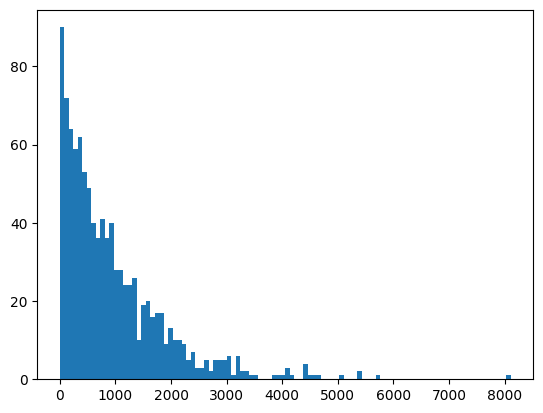

In [27]:
plt.hist(control_before, bins=100)
plt.show()

Предположим, что при наблюдении метрики в дальнейшем добавляется какой-то нормальный шум

In [28]:
control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

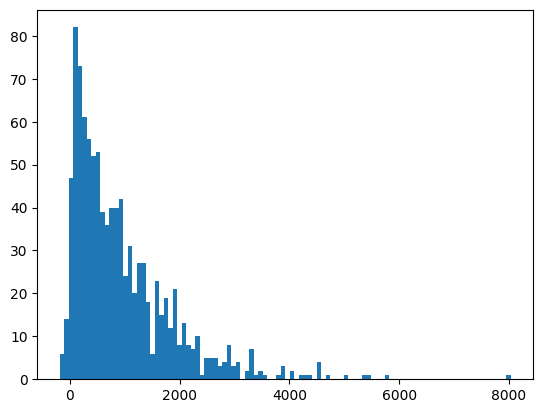

In [29]:
plt.hist(control, bins=100)
plt.show()

Теперь построим доверительный интервал для среднего значения нашей метрики и посмотрим, появилась ли стат значимая разница. Проведем такой эксперимент $10000$ раз

In [30]:
stats.norm(loc=control.mean(), scale=control.std() / np.sqrt(len(control))).ppf(
    [0.025, 0.975]
)

array([880.80593161, 996.1879594 ])

In [31]:
bad_cnt = 0

N = 10000
for i in tqdm(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)
    left_bound, right_bound = stats.norm(
        loc=control.mean(), scale=control.std() / np.sqrt(len(control))
    ).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев;")

100%|██████████| 10000/10000 [00:09<00:00, 1084.26it/s]

Стат значимая разница есть в 4.95% случаев;


Как мы видим такой тест ошибается в около $5$% случаев, так как находит разницу в среднем. Ваша задача построить CUPED-метрику основываясь на данной метрике и провести аналогичный тест

In [32]:
bad_cnt = 0

N = 10000
for i in tqdm(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

    # Вычисляем CUPED
    theta = np.cov(control, control_before)[0,1] / np.var(control_before)
    cuped_metric = control - theta * (control_before - control_before.mean())
    
    mean = cuped_metric.mean()
    std = cuped_metric.std() / np.sqrt(len(cuped_metric))
    left_bound, right_bound = stats.norm(loc=mean, scale=std).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

100%|██████████| 10000/10000 [00:09<00:00, 1082.31it/s]

Стат значимая разница есть в  84.84% случаев;


Результат должен получиться не очень хороший. Давайте теперь сделаем иначе: сгенерируем выборку из $10000$ значений, а затем выберем $2$ группы по $1000$ юзеров, которые будут нашими группами для теста. Опять добавим шум в обе группы аналогично тому, что показано в первом примере с теми же параметрами. Ваша задача вписать CUPED метрики используя знание обо всех $10000$ юзерах.

In [33]:
bad_cnt = 0
bad_cnt_original = 0

N = 10000
for i in tqdm(range(N)):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    # Уменьшаем масштаб шума для увеличения корреляции
    control_after_a = control_before_a + stats.norm(loc=0, scale=20).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=0, scale=20).rvs(
        samples_in_ab // 2
    )

    # Вычисляем CUPED
    theta = np.cov(np.concatenate([control_after_a, control_after_b]), 
                  control_before_full[:samples_in_ab])[0,1] / np.var(control_before_full[:samples_in_ab])
    
    control_cup_a = control_after_a - theta * (control_before_a - control_before_full[:samples_in_ab].mean())
    control_cup_b = control_after_b - theta * (control_before_b - control_before_full[:samples_in_ab].mean())

    # Тест без CUPED
    if stats.ttest_ind(control_after_a, control_after_b).pvalue < 0.05:
        bad_cnt_original += 1
    
    # Тест с CUPED
    if stats.ttest_ind(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt += 1
    
    # Диагностика в первой итерации
    if i == 0:
        print(f"Theta value: {theta}")
        print(f"Correlation between pre and post: {np.corrcoef(control_before_full[:samples_in_ab], np.concatenate([control_after_a, control_after_b]))[0,1]}")
        print(f"Original variance A: {np.var(control_after_a)}")
        print(f"Original variance B: {np.var(control_after_b)}")
        print(f"CUPED variance A: {np.var(control_cup_a)}")
        print(f"CUPED variance B: {np.var(control_cup_b)}")
        print(f"Variance reduction ratio: {np.var(control_cup_a)/np.var(control_after_a):.4f}")

print(f"Стат значимая разница без CUPED есть в {round(bad_cnt_original / N, 4) * 100}% случаев;")
print(f"Стат значимая разница с CUPED есть в {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 19/10000 [00:00<00:53, 184.85it/s]

Theta value: -0.010090474142879089
Correlation between pre and post: -0.010078040283187196
Original variance A: 1140166.9171090112
Original variance B: 997082.7439597017
CUPED variance A: 1163261.6677286138
CUPED variance B: 1017296.4114804664
Variance reduction ratio: 1.0203


100%|██████████| 10000/10000 [00:54<00:00, 183.01it/s]

Стат значимая разница без CUPED есть в 4.84% случаев;
Стат значимая разница с CUPED есть в 4.8500000000000005% случаев;


Результат получился уже совсем другой. Опишите свои мысли по поводу того, из-за чего возникает такая разница:



Далее проделаем такой же эксперимент при наличии реального смещения среднего значения и посмотрим на результаты с CUPED и без.

In [34]:
bad_cnt = 0
bad_cnt_cuped = 0

N = 10000
samples_in_ab = 2000  # Обязательно определить до использования

for i in tqdm(range(N)):
    # Шаг 1: Генерируем базовый уровень для каждого пользователя
    user_base_metrics = stats.norm(loc=100, scale=20).rvs(samples_in_ab)
    
    # Шаг 2: Разделяем на группы A и B
    indexes_to_take_a = np.random.choice(range(samples_in_ab), samples_in_ab // 2, False)
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]
    
    # Шаг 3: Pre-эксперимент значения (просто базовый уровень)
    pre_a = user_base_metrics[indexes_to_take_a]
    pre_b = user_base_metrics[indexes_to_take_b]
    
    # Шаг 4: Post-эксперимент значения (базовый уровень + эффект + шум)
    # Ключевой момент: маленький шум для высокой корреляции
    post_a = pre_a + stats.norm(loc=0, scale=5).rvs(len(pre_a))
    post_b = pre_b + stats.norm(loc=3, scale=5).rvs(len(pre_b))  # Эффект = 3
    
    # Шаг 5: Вычисляем CUPED
    # Используем все данные для оценки theta
    all_pre = np.concatenate([pre_a, pre_b])
    all_post = np.concatenate([post_a, post_b])
    
    # Формула CUPED
    theta = np.cov(all_post, all_pre)[0,1] / np.var(all_pre)
    
    # Применяем CUPED к обеим группам
    cuped_a = post_a - theta * (pre_a - all_pre.mean())
    cuped_b = post_b - theta * (pre_b - all_pre.mean())
    
    # Шаг 6: Проверяем мощность обычного t-теста
    if stats.ttest_ind(post_a, post_b).pvalue < 0.05:
        bad_cnt += 1
        
    # Шаг 7: Проверяем мощность CUPED t-теста
    if stats.ttest_ind(cuped_a, cuped_b).pvalue < 0.05:
        bad_cnt_cuped += 1
    
    # Диагностика для первой итерации
    if i == 0:
        print(f"Theta value: {theta}")
        print(f"Correlation between pre and post: {np.corrcoef(all_pre, all_post)[0,1]}")
        print(f"Original variance A: {np.var(post_a)}")
        print(f"Original variance B: {np.var(post_b)}")
        print(f"CUPED variance A: {np.var(cuped_a)}")
        print(f"CUPED variance B: {np.var(cuped_b)}")
        print(f"Variance reduction ratio: {np.var(cuped_a)/np.var(post_a):.2f}")
        print(f"Mean difference before CUPED: {np.mean(post_b) - np.mean(post_a)}")
        print(f"Mean difference after CUPED: {np.mean(cuped_b) - np.mean(cuped_a)}")

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев; при использовании CUPED -- в {round(bad_cnt_cuped / N, 4) * 100}% случаев")

  0%|          | 17/10000 [00:00<01:00, 166.26it/s]

Theta value: 0.9897047999546948
Correlation between pre and post: 0.9641272486080413
Original variance A: 385.4364497542697
Original variance B: 421.3221023889044
CUPED variance A: 25.91472094144322
CUPED variance B: 26.41885440085403
Variance reduction ratio: 0.07
Mean difference before CUPED: 2.8044214422157268
Mean difference after CUPED: 3.094123899727606


100%|██████████| 10000/10000 [00:54<00:00, 184.13it/s]

Стат значимая разница есть в 90.53% случаев; при использовании CUPED -- в 100.0% случаев


### Задание 4. Методы снижения дисперсии (2 балла)

В этой части задания вам нужно применить методы снижения дисперсии с лекций, чтобы провести более точные тесты по данным из файла.

Данные представляют собой значение какой-то метрики для трех возрастных групп пользователей. Столбец group отвечает за группу, в которой находятся пользователи: 
- `None` - пользователь не участвует в АБ тесте, 
- `*_before_i` - соответствующая группа до начала теста, 
- `*_after_i` - группа после начала эксперимента

Чем больше i, тем позже было сделано наблюдение. 

Cчитайте, что юзеры всегда идут в одном порядке в группах. То есть `data[data.group == 'control_before_i']`
дает юзеров в той же последовательности, что `data[data.group == 'control_after_i']` для всех i.  Аналогичное верно для тритмента.


#### Что надо сделать:
1. Напишите тест Стьюдента самостоятельно - то есть вы должны сами вычислить тестовую статистику, а затем используя квантильную функцию определить p-value. Квантили можно брать из готовых библиотек.

2. Реализуйте пост-стратификацию и CUPED. 

3. Проведите тесты между `control_before_i` и `treatment_before_i` снчала без применения пост-стратификации и CUPED, а затем с ними. Без применения каких-либо методов такой тест покажет p-value около $0.05$ только при i == 5. Ваша задача применить методы уменьшения дисперсии, чтобы с помощью теста Стьюдента можно было обнаружить отличие на уровне значимости $0.05$

4. Опишите свои результаты.

In [23]:
data = pd.read_csv("data_ab.csv")

In [24]:
data.head()

,age,metric,group
0,young,11309.036916,treatment_before
1,young,8496.554679,control_before
2,young,11891.862586,control_before
3,young,9229.445011,treatment_before
4,young,10410.961279,control_before


### Задание 5. Линеаризация + CUPED (2.5 балла)

1. В файле `duration_aa.csv` содержатся данные для АА-теста. Проверьте гипотезу о равенстве средних длительностей визита с помощью линеаризации, постройте распределение p-value.

2. Мы поменяли верстку нашего сайта и запустили АБ-тест, чтобы выяснить, увеличилась ли средняя продолжительность визита при новом дизайне. Результаты теста лежат в файле `duration_ab.csv`. С помощью линеаризованной метрики проверьте, есть ли разница в средней длительности визита между контрольной и тестовой группами.

3. Примените CUPED и снова проведите АБ-тест. Что произошло с p-value? Почему?

В каждом пункте необходимо визуализировать распределение p-value и сонаправленность линеаризованной разности метрик и разности ratio-метрик.